# importing all the necessary libraries

In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
import yfinance as yf


# Load data from Yahoo Finance

In [181]:
data=yf.download("AAPL", start="2024-01-01", end="2025-01-01")

[*********************100%***********************]  1 of 1 completed


In [207]:
data.tail()

Price,Close
Ticker,AAPL
Date,
2024-12-24,0.991334
2024-12-26,1.000000
2024-12-27,0.963748
2024-12-30,0.927919
2024-12-31,0.909105


In [183]:
data = data[['Close']]
data

Price,Close
Ticker,AAPL
Date,
2024-01-02,184.532089
2024-01-03,183.150391
2024-01-04,180.824356
2024-01-05,180.098709
2024-01-08,184.452545
...,...
2024-12-24,257.916443
2024-12-26,258.735504


## 2. Get Ticker Information

In [184]:
apple=yf.Ticker('AAPL')
# data.dividends
# data.income_stmt
# data.balancesheet
# apple.history(period='1mo')

# Data preprocessing

## check if any missing values

In [209]:

nulldata=data.isna().sum()
nulldata

Price  Ticker
Close  AAPL      0
dtype: int64

## remove the rows having null values

In [210]:
#drop the rows having null values
data.dropna(inplace=True)
data.head()

Price,Close
Ticker,AAPL
Date,
2024-01-02,0.214870
2024-01-03,0.200250
2024-01-04,0.175639
2024-01-05,0.167961
2024-01-08,0.214028


## Applying MinMaxScaler to the data


In [211]:
minmax=MinMaxScaler()
data['Close']=minmax.fit_transform(data['Close'].values.reshape(-1,1))
data.shape

(252, 1)

# Create sequences

In [188]:
len(data)

252

In [189]:
def create_sequence(data, time_step):
    X, Y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step])  # Sequence of time steps
        Y.append(data[i + time_step])    # Target value (next step after the sequence)
    return np.array(X), np.array(Y)
#consider time_step to be 60 
time_step=60
X,Y=create_sequence(data['Close'].values,time_step)
X=X.reshape(X.shape[0],X.shape[1],1)    #reshape the data to 3D array (samples, time steps, features)

    
    

In [190]:
X.shape


(192, 60, 1)

In [191]:
Y.shape


(192, 1)

# Train test split

In [192]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42,shuffle=False)
X_train.shape

(153, 60, 1)

# Build LSTM for Prediction

In [217]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(1)
])


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Compile the model

In [218]:
model.compile(
    optimizer='adam',
    loss='mean_squared_error' ,
    metrics=['mean_absolute_error']
)

## training the model

In [219]:
model.fit(X_train,Y_train,epochs=50,validation_data=(X_test,Y_test),batch_size=32,verbose=2)

Epoch 1/50
5/5 - 6s - 1s/step - loss: 0.2072 - mean_absolute_error: 0.3981 - val_loss: 0.1948 - val_mean_absolute_error: 0.4299
Epoch 2/50
5/5 - 0s - 68ms/step - loss: 0.0301 - mean_absolute_error: 0.1420 - val_loss: 0.0329 - val_mean_absolute_error: 0.1627
Epoch 3/50
5/5 - 0s - 68ms/step - loss: 0.0301 - mean_absolute_error: 0.1514 - val_loss: 0.0075 - val_mean_absolute_error: 0.0786
Epoch 4/50
5/5 - 0s - 77ms/step - loss: 0.0097 - mean_absolute_error: 0.0798 - val_loss: 0.0470 - val_mean_absolute_error: 0.2009
Epoch 5/50
5/5 - 0s - 76ms/step - loss: 0.0149 - mean_absolute_error: 0.1062 - val_loss: 0.0370 - val_mean_absolute_error: 0.1752
Epoch 6/50
5/5 - 0s - 75ms/step - loss: 0.0089 - mean_absolute_error: 0.0771 - val_loss: 0.0097 - val_mean_absolute_error: 0.0848
Epoch 7/50
5/5 - 0s - 77ms/step - loss: 0.0081 - mean_absolute_error: 0.0703 - val_loss: 0.0053 - val_mean_absolute_error: 0.0651
Epoch 8/50
5/5 - 0s - 75ms/step - loss: 0.0075 - mean_absolute_error: 0.0672 - val_loss: 0.0

## predictions on test data

In [220]:
Y_pred=model.predict(X_test)
Y_pred.shape

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 488ms/step


(39, 1)

## Inverse transform the predictions and actual data into original scale

In [ ]:
# Preprocess the data
actual_data=minmax.inverse_transform(Y_test)
predicted_data=minmax.inverse_transform(Y_pred)#not reshaping the data as it is already in 2D array

In [ ]:
predicted_data[:5]


array([[0.68292946],
       [0.67285144],
       [0.66285765],
       [0.6561328 ],
       [0.6516227 ]], dtype=float32)

# Evaluate the model

In [ ]:
model.evaluate(X_test,Y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - Accuracy: 0.0171 - loss: 0.0067    


[0.007108771707862616, 0.025641025975346565]

## calculating meansquared error,r2score


In [224]:
r2score=r2_score(actual_data,predicted_data)
print(f"R2 Score: {r2score:.4f}")
mean_squared_error_value=mean_squared_error(actual_data,predicted_data)
print(f"Mean Squared Error: {mean_squared_error_value:.4f}")


R2 Score: 0.4987
Mean Squared Error: 0.0074


# Visualize the results

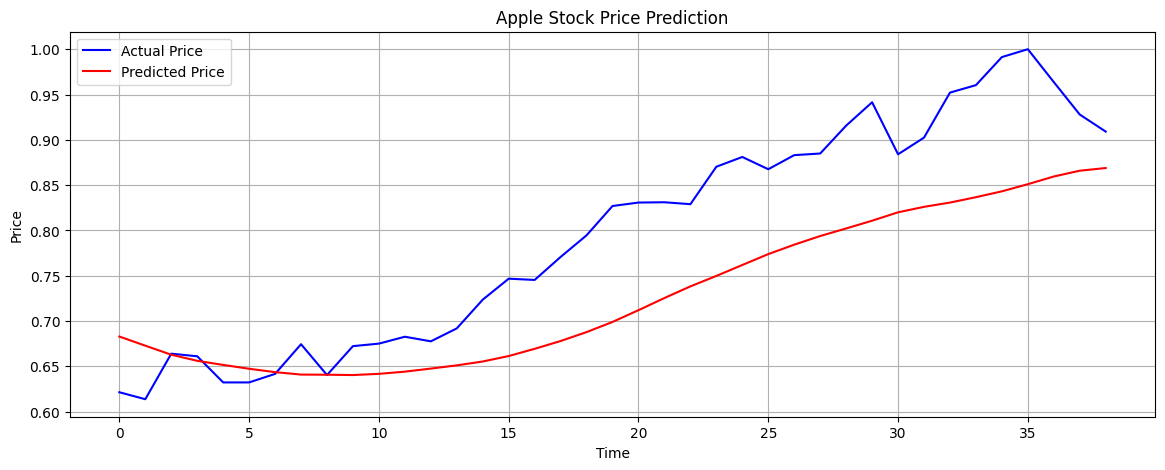

In [226]:
plt.figure(figsize=(14,5))
plt.plot(actual_data, label='Actual Price', color='blue')
plt.plot(predicted_data, label='Predicted Price', color='red')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()